# Max-min fairness

In this notebook, we evaluate the impact of splitting larger optimization problems into smaller sub-problems on policy runtime and quality of solution for max-min fairness policies.

## Import statements

In [1]:
import sys; sys.path.append("../../..")
from job_id_pair import JobIdPair
import utils
from plotting_utils import plot_runtimes, plot_effective_throughput_ratios
from plotting_utils import plot_runtime_vs_effective_throughput_ratios

import copy
import numpy as np
import random
import time

np.set_printoptions(precision=3, suppress=True)

## Harness that runs a policy with the passed-in number of sub-clusters

In [2]:
def create_problem_instance(num_jobs, cluster_spec,
                            policy_name,
                            seed,
                            introduce_skew=False):
    oracle_throughputs = utils.read_all_throughputs_json_v2("../../../simulation_throughputs.json")
    rng = random.Random()
    rng.seed(seed)
    jobs = {}
    throughputs = {}
    scale_factors = {}
    priority_weights = {}
    for i in range(num_jobs):
        job_id = JobIdPair(i, None)
        job = utils.generate_job(throughputs=oracle_throughputs,
                                 rng=rng, job_id=job_id)
        jobs[job_id[0]] = job
        job_type_key = (job.job_type, job.scale_factor)
        throughputs[job_id] = {}
        for worker_type in cluster_spec:
            throughputs[job_id][worker_type] = \
                oracle_throughputs[worker_type][job_type_key]['null']
        scale_factors[job_id] = 1
        if introduce_skew:
            priority_weights[job_id] = (i % 4) + 1.0
        else:
            priority_weights[job_id] = 1.0
    if 'pack' in policy_name:
        for i in range(num_jobs):
            job_type_key = (jobs[i].job_type, jobs[i].scale_factor)
            for j in range(num_jobs):
                if i < j and jobs[i].scale_factor == jobs[j].scale_factor:
                    other_job_type_key = \
                        (jobs[j].job_type, jobs[j].scale_factor)
                    throughputs[JobIdPair(i, j)] = {}
                    for worker_type in cluster_spec:
                        throughputs[JobIdPair(i, j)][worker_type] = \
                            oracle_throughputs[worker_type][job_type_key][other_job_type_key]
    return throughputs, scale_factors, priority_weights

In [3]:
def harness(policy, throughputs, scale_factors, priority_weights, cluster_spec, num_sub_clusters=1,
            random_cluster_assignment=False):
    start_time = time.time()
    sub_cluster_throughputs = []
    sub_cluster_scale_factors = []
    sub_cluster_priority_weights = []
    job_to_sub_cluster_assignment = {}
    job_ids = []
    for job_id in throughputs:
        if not job_id.is_pair():
            job_ids.append(job_id)
    for i, job_id in enumerate(job_ids):
        if random_cluster_assignment:
            job_to_sub_cluster_assignment[job_id[0]] = random.randint(0, num_sub_clusters-1)
        else:
            job_to_sub_cluster_assignment[job_id[0]] = job_id[0] % num_sub_clusters
    for i in range(num_sub_clusters):
        sub_cluster_throughputs.append({})
        sub_cluster_scale_factors.append({})
        sub_cluster_priority_weights.append({})
        for job_id in throughputs:
            if (job_to_sub_cluster_assignment[job_id[0]] == i) and (
                 not job_id.is_pair() or (job_to_sub_cluster_assignment[job_id[1]] == i)):
                sub_cluster_throughputs[-1][job_id] = copy.copy(throughputs[job_id])
                if not job_id.is_pair():
                    sub_cluster_scale_factors[-1][job_id] = scale_factors[job_id]
                    sub_cluster_priority_weights[-1][job_id] = priority_weights[job_id]
    sub_cluster_cluster_spec = {worker_type: cluster_spec[worker_type] // num_sub_clusters
                                for worker_type in cluster_spec}
    setup_time = time.time() - start_time
    full_allocation = {}
    computation_times = []
    for i in range(num_sub_clusters):
        start_time = time.time()
        if policy._name.startswith('MaxMinFairness'):
            sub_cluster_allocation = policy.get_allocation(
                sub_cluster_throughputs[i], sub_cluster_scale_factors[i],
                sub_cluster_priority_weights[i], sub_cluster_cluster_spec)
        else:
            sub_cluster_allocation = policy.get_allocation(
                sub_cluster_throughputs[i], sub_cluster_scale_factors[i],
                sub_cluster_cluster_spec)
        for job_id in sub_cluster_allocation:
            full_allocation[job_id] = sub_cluster_allocation[job_id]
        computation_times.append(time.time() - start_time)
    return full_allocation, setup_time + max(computation_times)

In [4]:
def sweep(policy_names_and_num_sub_clusters,
          all_num_jobs,
          num_trials, introduce_skew=False, solver='ECOS'):
    all_runtimes = {}
    all_effective_throughputs = {}
    for num_jobs in all_num_jobs:
        all_runtimes[num_jobs] = []
        all_effective_throughputs[num_jobs] = []
        cluster_spec = {
            'v100': max(num_jobs // 4, 1),
            'p100': max(num_jobs // 4, 1),
            'k80': max(num_jobs // 4, 1),
        }
        for i in range(num_trials):
            throughputs, scale_factors, priority_weights = \
                create_problem_instance(num_jobs, cluster_spec,
                                        policy_names_and_num_sub_clusters[0][0], seed=i,
                                        introduce_skew=introduce_skew)
            all_runtimes[num_jobs].append([])
            allocations = []
            for (policy_name, num_sub_clusters) in policy_names_and_num_sub_clusters:
                policy = utils.get_policy(policy_name, solver='SCS')
                allocation, runtime = harness(
                    policy, throughputs,
                    scale_factors,
                    priority_weights,
                    cluster_spec,
                    num_sub_clusters=num_sub_clusters)
                all_runtimes[num_jobs][-1].append(runtime)
                allocations.append(allocation)

            all_effective_throughputs[num_jobs].append([])
            for allocation in allocations:
                effective_throughputs = {}
                for job_id in allocation:
                    for single_job_id in job_id.singletons():
                        if single_job_id not in effective_throughputs:
                            effective_throughputs[single_job_id] = 0.0
                    for worker_type in allocation[job_id]:
                        if job_id.is_pair():
                            for i, single_job_id in enumerate(job_id.singletons()):
                                effective_throughputs[single_job_id] += (
                                   allocation[job_id][worker_type] *
                                   throughputs[job_id][worker_type][i]
                                )
                        else:
                            effective_throughputs[job_id] += (
                                allocation[job_id][worker_type] *
                                throughputs[job_id][worker_type])
                all_effective_throughputs[num_jobs][-1].append(effective_throughputs)
    return all_runtimes, all_effective_throughputs

## Effective throughputs and runtimes

In [5]:
def get_runtimes_and_effective_throughputs(policy_name, all_num_sub_clusters,
                                           num_jobs, introduce_skew=False,
                                           solver='ECOS'):
    policy_names_and_num_sub_clusters = [
        (policy_name, num_sub_clusters)
        for num_sub_clusters in all_num_sub_clusters
    ]
    if not introduce_skew:
        policy_names_and_num_sub_clusters.append(
            ('gandiva', 1))
    all_runtimes, all_effective_throughputs = sweep(
        policy_names_and_num_sub_clusters, [num_jobs],
        num_trials=1, introduce_skew=introduce_skew, solver=solver)
    runtimes = all_runtimes[num_jobs][0]
    all_effective_throughputs = all_effective_throughputs[num_jobs][0]
    return runtimes, all_effective_throughputs

Original 1837.2635431289673 1.0 0.0
POP-2 173.74952745437622 0.9993083144477002 0.007878515437563764
POP-4 24.622868061065674 0.9990209858423391 0.009294896128721591
POP-8 4.530709981918335 0.9972380158914118 0.014228200752617187
Gandiva 68.3949043750763 0.5257595150336349 0.1640541553053958


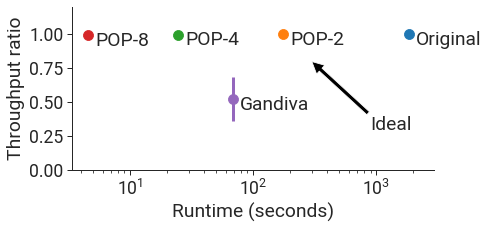

In [6]:
import ast
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
with open('num_jobs=1024.out', 'r') as f:
    runtimes = f.readline().strip()
    runtimes = ast.literal_eval(runtimes)
    all_effective_throughputs = f.readline().strip()
    all_effective_throughputs = ast.literal_eval(all_effective_throughputs)

plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    draw_arrow=True,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=1024.pdf")

(524800, 3)
tputs  (1048576, 3)
indexed vars  (1048576, 3)
reshaped tputs  (1024, 3072)
1
1024
1 obj
getting base constr
3
                                     CVXPY                                     
                                    v1.1.10                                    
(CVXPY) Mar 04 11:54:19 AM: Your problem has 1574400 variables, 3 constraints, and 0 parameters.
(CVXPY) Mar 04 11:54:19 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 04 11:54:19 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 04 11:54:19 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 04 11:54:19 AM: Compilin

/home/akshay/src/cvxgrp/cvxpy/cvxpy/problems/problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Original 39.366679668426514 1.0 0.0
POP-2 50.779709339141846 0.46990513217400837 0.23385938393827327


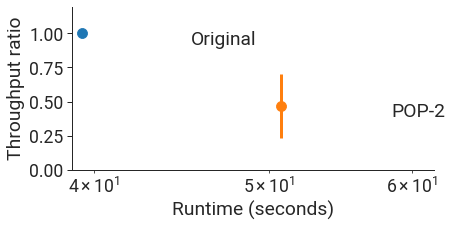

In [8]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
#all_num_sub_clusters = [1, 2, 4, 8]
all_num_sub_clusters = [1]

import cvxpy as cp
cp.set_num_threads(8)
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           1024, solver='SCS')

plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=256.pdf")

In [ ]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           256,
                                           introduce_skew=True)
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/skewed_num_jobs=256.pdf")

In [ ]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           512)
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=512.pdf")

In [ ]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           512,
                                           introduce_skew=True)
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/skewed_num_jobs=512.pdf")

## Runtimes

In [10]:
def get_runtimes(policy_name, all_num_jobs, introduce_skew=False):
    data = {
        'policy': [],
        'num_jobs': [],
        'runtimes': []
    }
    all_num_sub_clusters = [1, 4, 16]
    policy_names_and_num_sub_clusters = [
        (policy_name, num_sub_clusters)
        for num_sub_clusters in all_num_sub_clusters
    ]
    policy_labels = ['Vanilla', '4 sub-clusters', '16 sub-clusters']
    all_runtimes, _ = sweep(policy_names_and_num_sub_clusters,
                            all_num_jobs,
                            num_trials=1,
                            introduce_skew=introduce_skew)
    for num_jobs in all_runtimes:
        for i in range(len(all_runtimes[num_jobs])):
            for (policy_label, runtime) in zip(
                policy_labels, all_runtimes[num_jobs][i]):
                data['policy'].append(policy_label)
                data['num_jobs'].append(num_jobs)
                data['runtimes'].append(runtime)
    return data

In [13]:
all_num_jobs = [64, 128, 256, 512, 1024, 2048,
                4096, 8192, 16384, 32768]
xticks = [64, 512, 4096, 32768]
yticks = [2**-8, 2**-5, 2**-2, 2**1, 2**4, 2**7]
yticklabels = [0.004, 0.031, 0.25, 2, 16, 128]
plot_runtimes(get_runtimes('max_min_fairness_perf',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=False),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels,
              output_filename="runtimes/max_min_fairness_perf.pdf")
plot_runtimes(get_runtimes('max_min_fairness_perf',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=True),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels)

Failure:Interrupted


SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
# TODO: Increase to 1024.
all_num_jobs=[64, 128, 256, 512]
xticks = [64, 128, 256, 512]
yticks = [2**-5, 2**-2, 2**1, 2**4, 2**7]
yticklabels = [0.031, 0.25, 2, 16, 128]
plot_runtimes(get_runtimes('max_min_fairness_packed',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=False),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels,
              output_filename="runtimes/max_min_fairness_packed.pdf")
plot_runtimes(get_runtimes('max_min_fairness_packed',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=True),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels)

## Effective throughput ratios

In [ ]:
def get_effective_throughput_ratios(policy_name, num_jobs, introduce_skew=False,
                                    random_cluster_assignment=False):
    random.seed(42)
    all_num_sub_clusters = [1, 4, 16]
    policy_names_and_num_sub_clusters = [
        (policy_name, num_sub_clusters)
        for num_sub_clusters in all_num_sub_clusters
    ]
    _, all_effective_throughputs = sweep(
        policy_names_and_num_sub_clusters,
        [num_jobs],
        num_trials=1,
        introduce_skew=introduce_skew)
    return all_effective_throughputs[num_jobs][0]

In [ ]:
print("No skew")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_perf', 64),
    output_filename="effective_throughput_ratios/max_min_fairness_perf.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_perf', 64),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_perf_cdf.pdf")
print("Skew and round-robin placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_perf', 64,
        introduce_skew=True),
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('max_min_fairness_perf', 64,
                                    introduce_skew=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed_cdf.pdf")
print("Skew and random placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('max_min_fairness_perf', 64,
                                    introduce_skew=True,
                                    random_cluster_assignment=True),
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed_random.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('max_min_fairness_perf', 64,
                                    introduce_skew=True,
                                    random_cluster_assignment=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed_random_cdf.pdf")

In [ ]:
print("No skew")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64),
    output_filename="effective_throughput_ratios/max_min_fairness_packed.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_packed_cdf.pdf")
print("Skew and round-robin placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
    introduce_skew=True),
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
        introduce_skew=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed_cdf.pdf")
print("Skew and random placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
         introduce_skew=True,
    random_cluster_assignment=True),
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed_random.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
        introduce_skew=True,
        random_cluster_assignment=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed_random_cdf.pdf")